# Finding topic clusers in tech news: using unsupervized learning to cluster news articles based on content

#### Micaela McCall

In my reading of tech news, I struggle to identify topics or themes that interested me and were worth my time.

While tags can be helpful to get a sense of an article outside of the title, many of them seem to reference vague, poorly defined or refined terms.  Rather than relying on these tags, I wanted to see if unsupervised learning could help me identify themes or groups of themes to assist in my reading. 

![gif](https://media.giphy.com/media/UV8mPZc6WjCrm/giphy.gif)

## Dataset

I scraped article title, content, date, author, and url were from the tech sections of the following news sites:
- Vox
- Vice
- New York Times
- Wired
- The Atlantic
- BuzzFeed
- The Gradient

## Project Goals

I aimed to find clusters in tech news articles based on the full content of the article and understand themes or constructs that can summarize the clusters.

## Data collection: News Scrapers

The code to scrape the articles is located in the `scrape_news` directory.

The settings file contains the settings for scrapy and splash, as well as detemines which of the above publications to scrape from. 

In [1]:
from settings import *

Verifying current working directory, which is: /Users/micamccall/Documents/python_projects/tech-news-cluster/tech_news_cluster
Python is checking for modules in this directory


### Run the scrapers
This code imports and runs the scrapy spiders, saving the data as `.csv` in the `data` folder (which is created by the settings file)

In [3]:
from scrape_news.scrape_news.spiders.spiders import *
from scrape_news.scrape_news.spiders.js_spiders import *
from scrapy.utils.project import get_project_settings
from scrapy.crawler import CrawlerProcess

class Scraper:
    def __init__(self):
        # set scrapy settings variable to my settings file
        os.environ['SCRAPY_SETTINGS_MODULE'] = 'settings'
        settings_module_path = os.environ['SCRAPY_SETTINGS_MODULE']
        settings = get_project_settings()
        # Initialize crawler with these settings
        self.process = CrawlerProcess(settings)
    def run_spiders(self):
        # Crawl a spider for each publication set in settings
        for pub in PUBLICATIONS:
            spider = eval(pub + "Spider")
            self.process.crawl(spider)
        # Start the process
        self.process.start()

# Initialize and run the spiders
scraper = Scraper()     
scraper.run_spiders()

## Load data
From the `data` folder

In [10]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

def load_news_data():
    """
    A function to load scraped news data from data folder
    """
    # List of files
    files = [f for f in os.listdir(DATA_PATH) if f.endswith(".csv")]
    
    # List of data frames
    file_list = []
    
    # Append each data frame in files to the file_list
    for filename in files:
        df = pd.read_csv(os.path.join(DATA_PATH, filename))
        file_list.append(df)
        
    # Concatenate all the news data frames
    df_full = pd.concat(file_list, join='outer').drop_duplicates().reset_index().drop(columns='index')
    
    return df_full

# Drop NAs in content column
news_df = load_news_data().dropna(subset=['content'])
news_df.shape

(1389, 7)

## Text processing

First thing to do is clean and process the text in the `content` column. This process involves:

- tokenized the content (splitting it into its constituent words)
- removed stopwords and proper nouns 
- reduce words to their lemmas (the root word)

I used SpaCy for this. SpaCy comes with a bunch of pre-built models that tokenize words and also determine if they are alphanumeric, stop words, find their part of speech, lemma, etc.

In [4]:
import spacy

# Initialize spacy with the english model
sp = spacy.load('en_core_web_sm')

The function below tokenizes a text string and determines if each token is a proper noun, alphanumeric character, or stop word. Then if it is NOT a proper noun, IS alphanumeric, and is NOT a stop word, it appends the LEMMA of the word to a new, cleaned string.

In [4]:
from functools import lru_cache

@lru_cache(maxsize = None)
def clean_string(text_string):
    '''
    A function to clean a string using SpaCy, removing stop-words, non-alphanumeric characters, and pronouns

    Argument: a text string
    Output: a cleaned string

    '''

    # Parse the text string using the english model initialized earlier
    doc = sp(text_string)
    
    # Initialize empty string
    clean = []

    # Add each token to the list if it is not a stop word, is alphanumeric, and if it's not a pronoun
    for token in doc:
        
        if token.is_alpha == False or token.is_stop == True or token.lemma_ == '-PRON-':
            pass
        else:
            clean.append(token.lemma_)

    # Join the list into a string
    clean = " ".join(clean)

    return clean

### Here's an example of how the text cleaning works:

In [6]:
example = news_df.loc[2,'content']
example_clean = clean_string(example)
print("Raw example: \n" + example[:500]+ "\n \n")
print("Clean exmaple: \n" + example_clean[:500])

Raw example: 
Progress in the field of Natural Language Processing (NLP) depends on the existence of language resources: digitized collections of written, spoken or signed language, often with gold standard labels or annotations reflecting the intended output of the NLP system for the task at hand (e.g. the gold standard text for a speech recognition system or gold standard user intent labels in a dialogue system such as Siri, Alexa or Google Home). Unsupervised, weakly supervised, semi-supervised, or distant
 

Clean exmaple: 
progress field natural language processing nlp depend existence language resource digitize collection write speak sign language gold standard label annotation reflect intend output nlp system task hand gold standard text speech recognition system gold standard user intent label dialogue system siri alexa google home unsupervised weakly supervised semi supervised distantly supervise machine learning technique reduce overall dependence label datum approach need su

### Next I cleaned and appended the cleaned content to the news data frame

In [11]:
def clean_content(df):
    '''
    A function to clean all the strings in a whole of a corpus

    Argument: a dataframe with the column 'content'
    Ouput: same dataframe with a new 'cleaned_content' column
    '''

    # Initialize list of cleaned content strings
    clean_content= []

    # Call clean_string() for each row in the data frame and append to clean_content list
    for row in df.content:

        clean_content.append(clean_string(row))

    # Append clean_content list to the data frame
    df['clean_content'] = clean_content

    return df 

news_df = clean_content(news_df)

## Vectorization of text data 
Now it's time to create the feature matrix that will be used in the KMeans model, which involves vectorizing the text data. 

Sometimes people use a bag-of-words representation, which is just a count of how many time each word in the whole corpus appears in each document. 

Instead of doing a pure count, you can also scale the feature based on the it's relative frequency. If a word appears a lot in some documents but not in most, it is likely to be informative; if it appears often in most documents, it likely isn't.

This is done with a with tf-idf vectorizer (term-frequency inverse-document-frequency) from Scikit-learn. This function also applies L2 regularization, which makes it so that the length of the document does not change the representation. 

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(analyzer = 'word', min_df = 5, ngram_range = (1,3), max_df = 0.15)

I initialized the vectorizer with settings to use only words that appear in more than 5 documents, in order to cut back on tokens. Additionally, for unsuperized learning, sklearn recommends taking out common words, so I took out words that appear in more than a 15% of documents

### N-grams

The Tfidf Vectorizer will tokenize on combinations of words (n-grams) instead of just single words (1-gram). I chose to do 1-, 2-, and 3-grams because doing more can cause the number of features to explode.

In [12]:
X = vectorizer.fit_transform(news_df['clean_content'])
X.shape

(1389, 25360)

## Inspecting the text features

Using the vectorizer to transform the data returns the sparse tf-idf weighted document-term matrix.

The rows is the number of documents in the corpus, and the columns are the number of terms (1-, 2-, and 3-grams) in the corpus.

To get that matrix, Tfidf Vectorizer multiples the idf (inverse document frequency) vector by the document term frequency. The idf gives lower score to terms that appear more frequently across documents because they are deemed to be less important.

### Word clouds for visualizing terms with highest and lowest tf-idf scores
I inspected which words tf-idf found most important and least important terms in distinguishing specific documents.

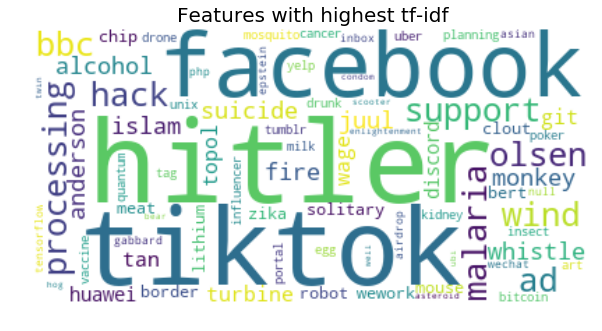

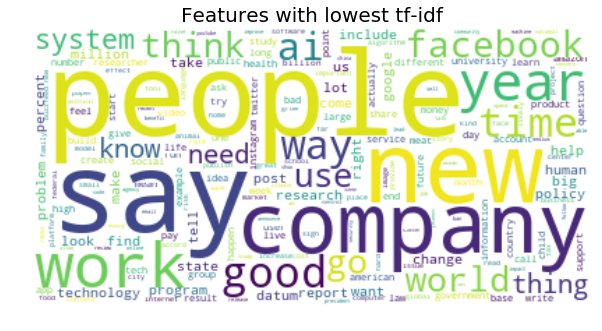

In [14]:
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Get the list of terms in the vocabulary
terms = vectorizer.get_feature_names() 
# Make the matrix dense 
tfidf = X.todense() 
# Get the max tfidf weight of each term and flatten to a 1D array
tfidf_max = np.array(tfidf.max(axis = 0)).ravel()


def plot_tfidf_word_cloud(frequencies = tfidf_max, terms = terms, most_frequent = True):

    '''
    Plots a word cloud for the most important or least frequent words in a list
    
    Arguments: 
    frequencies: a (terms,) sized array of frequencies
    terms: a list or array of terms
    most_frequent: if True, plots most frequent, if False, plots least frequent 
    
    Ouput: a word cloud
    
    '''
    # Sort frequency array in ascending and returns an array of indices
    sorted_frequencies = frequencies.argsort()

    # Create word cloud with highest or lowest 75 terms, joined into a string
    if most_frequent == True:
        cloud = WordCloud(background_color = 'white').generate(text=(' '.join(np.array(terms)[sorted_frequencies[-75:]])))
        title = "Features with highest tf-idf"
    else:
        cloud = WordCloud(background_color = 'white').generate(text = (' '.join(np.array(terms)[sorted_frequencies[75:]])))
        title = "Features with lowest tf-idf"
    
    plt.figure(figsize = [10,15])
    plt.imshow(cloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, size =20)
    plt.show();


plot_tfidf_word_cloud()
plot_tfidf_word_cloud(most_frequent = False)

### Lower scores mean less informative, higher mean more

We can see that the words with higher tf-idf scores distinguish individual topics, such as individual people (Bezos, Hitler, Olsen), specific machine learning or coding (brain, hack, processing), or current events (malaria, suicide, wind).

The words with lower tf-idf scores are clearly more generic and don't distinguish specific topics. Iterestingly, AI is in this group, which indicates that the term "AI" is used indiscriminately and widely and does not distinguish specific documents in this corpus, which may indicate something about the use of the words or about the general theme of topics in this corpus.

# Time for KMeans clustering!

Next I ran this unsupervised clustering algorithm to discover groups in the text data

## Choosing the best number of clusters

Without group truth labels with which to evaluate kmeans, detemining parameters like number of clusters can be difficult. 

One way to evaluate kmeans without ground truth is the within cluster sum of squared errors (distortion). Lower scores are generally better because they mean tighter clusters.

Another way is through silhouette score, which measures the distance between clusters by measuring how close each point in one cluster is to the neighboring cluster. It is a measure between [-1,1], where higher scores are generally better because they mean more distinct clusters. 

**The best number of clusters will cause the SSE curve to bend, and also maximize the silhouette score.**

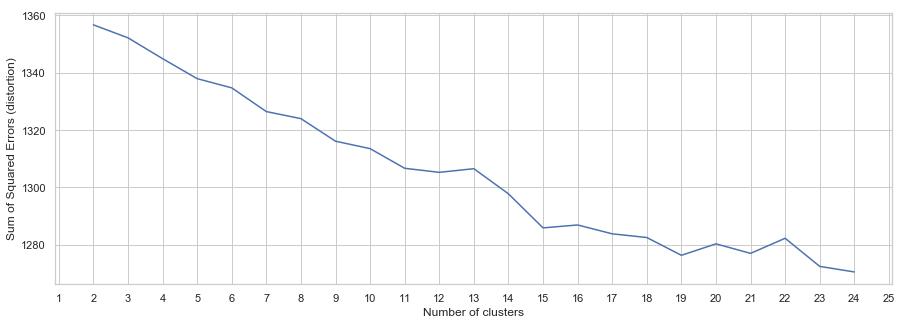

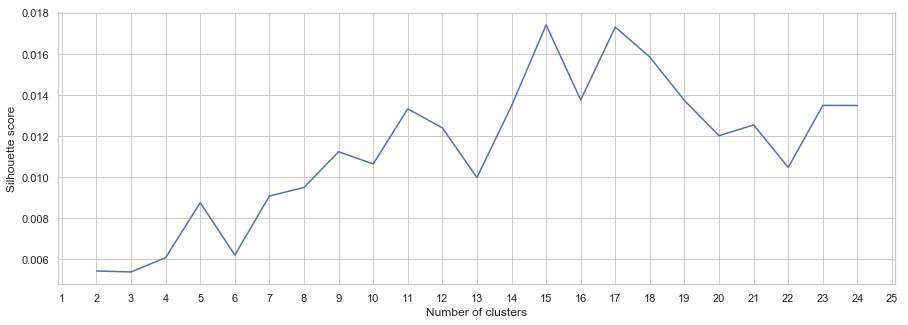

In [15]:
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.ticker as ticker
import seaborn as sns

def choose_k(max_k):
    '''
    A function to display plots of average silhouette score and average SSE (inertia) for various numbers of clusters

    Arguments: max_k = the maximum number of clusters to test 

    Ouput: line plots for both silhouette scores and SSE
    '''

    # Initialize empty lists
    distortions = []
    sil_score = []

    # For each value of k, initialize and fit a MiniBatchKMeans and append the sillhouette score and SSE to the lists
    for k in range(2, max_k):
        kmeans = MiniBatchKMeans(n_clusters = k, init = 'k-means++', max_iter = 1000, random_state=42)
        kmeans.fit(X)
        sil_score.append(silhouette_score(X, kmeans.labels_))
        distortions.append(kmeans.inertia_)

    # Plot each score for each number of clusters
    sns.set(style="whitegrid")
    plt.figure(figsize=(15, 5))
    distortions_plot = sns.lineplot(x= range(2,max_k),y= distortions)
    plt.ylabel("Sum of Squared Errors (distortion)")
    plt.xlabel("Number of clusters")
    distortions_plot.xaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()
    plt.close()

    plt.figure(figsize=(15,5))
    silhouette_plot = sns.lineplot(x= range(2,max_k),y= sil_score)
    plt.ylabel("Silhouette score")
    plt.xlabel("Number of clusters")
    silhouette_plot.xaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

    
choose_k(25)

### I chose 14 clusters becuase going from 14 to 15 increases the SSE for the first time in the plot, and largely decreases average silhouette score

In [16]:
k = 15

## Training the KMeans model

In [17]:
from sklearn.cluster import KMeans
kmeans =  KMeans(n_clusters = k, init = 'k-means++', random_state= 42)

cluster_labels = kmeans.fit_predict(X)

## Inspecting the clusters

#### Silhouette scores

First, I inspected the distinctness of the clusters by plotting the silhouette values of each document.

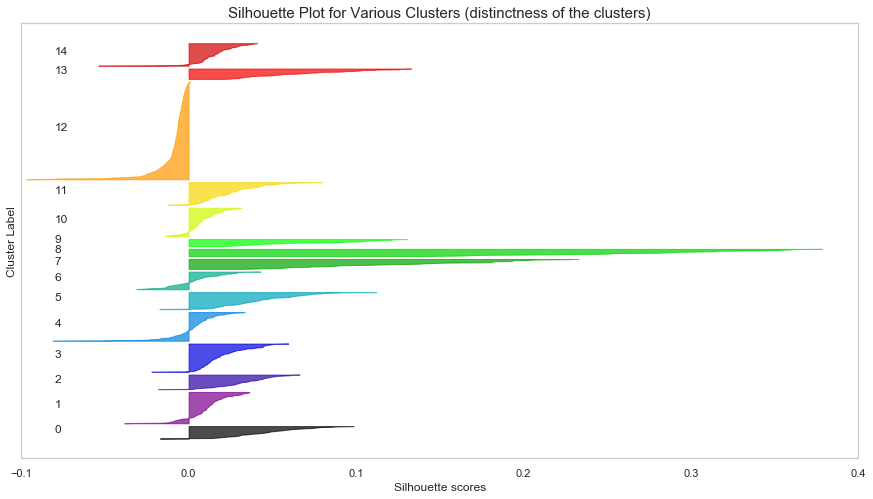

In [18]:
import matplotlib.cm as cm

def plot_silhouette_scores(k):
    '''
    A function to plot the silhouette scores in each cluster of the kmeans model
    '''

    # An array of the silhouette score of each sample (article) 
    sample_sil_values = silhouette_samples(X, cluster_labels)

    fig, (ax1) = plt.subplots(figsize = [15,8])

    # For each cluster, plot the silhouette scores for each sample
    y_lower = 10
    for i in range(k):

        # Values for each cluster
        ith_cluster_sil_values = sample_sil_values[cluster_labels == i]

        ith_cluster_sil_values.sort()

        # How many samples are in that cluster
        size_cluster_i = ith_cluster_sil_values.shape[0]

        # The upper limit of that cluster group is the lower limit plus the size of the cluster
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / k)

        # Fill the length of the silhouette score on the x axis, on the y axis between the upper and lower limits of the cluster group 
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_sil_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.08, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 0.4])
    ax1.grid(False)
    ax1.set_ylabel("Cluster Label")
    ax1.set_xlabel("Silhouette scores")
    ax1.set_title("Silhouette Plot for Various Clusters (distinctness of the clusters)", size = 15)

plot_silhouette_scores(k)

Higher silhouette scores mean more distinct clusters. Negative scores mean that that sample is closer to the center of another cluster than it's own center. We can see that cluster 12 has lots of negative scores: it's not very distinct.

#### Top words by cluster
Next, I printed several 1-gram terms that represent the largest coordinate values in the high-dimensional cluster centers. These terms are more important in determining the cluster center and thus more important for the cluster. 

In [19]:
def print_top_words_by_cluster(k):

    '''
    A function to plot the top terms in each cluster of the kmeans model
    '''
    # The high dimensional coordinates of the center of each cluster (shape is 15 by the number of features)
    # Within each cluster (row) sort the coordinate of each features them in descending order and return array of indices
    sorted_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

    for i in range(k):
        print("Cluster %d:" % i, end='')
        for ind in sorted_centroids[i, :12]:
            if terms[ind].find(' ') == -1:
                print(' %s' % terms[ind], end='')
        print()

print("Top words in each cluster: \n" )
print_top_words_by_cluster(k)

Top words in each cluster: 

Cluster 0: tiktok china chinese huawei hong kong xinjiang camp uighurs beijing internment
Cluster 1: learning openai robot art deep train neural task dataset
Cluster 2: charity tax foundation philanthropy gates donate billionaire kidney donor donation wealth giving
Cluster 3: instagram influencer youtube ad meme follower brand tumblr creator star tweet fan
Cluster 4: patient vaccine nuclear disease outbreak ebola brain weapon egg cancer medical crispr
Cluster 5: climate carbon energy emission fire air pollution gas renewable fuel clean
Cluster 6: apple camera device portal iphone ring airpods store police privacy card headphone
Cluster 7: facial recognition surveillance police camera ban privacy
Cluster 8: meat burger plant beyond impossible foods vegan
Cluster 9: opioid prison drug gun addiction justice crime criminal sackler incarceration purdue
Cluster 10: deepfake election tweet musk zuckerberg fake unsworth court voter whatsapp
Cluster 11: programming 

KMeans clustering, because it's unsupervized, can sometimes cluster based on constructs that we aren't interested in. However, looking at the top words in each cluster, it appears that each cluster represents a reasonal topic in the realm of the articles I was looking at.

## Plot clusters in 2 dimensions using t-SNE

t-SNE is a feature reduction technique that reduces features to 2 dimensions, mainly used just for plotting purposes.

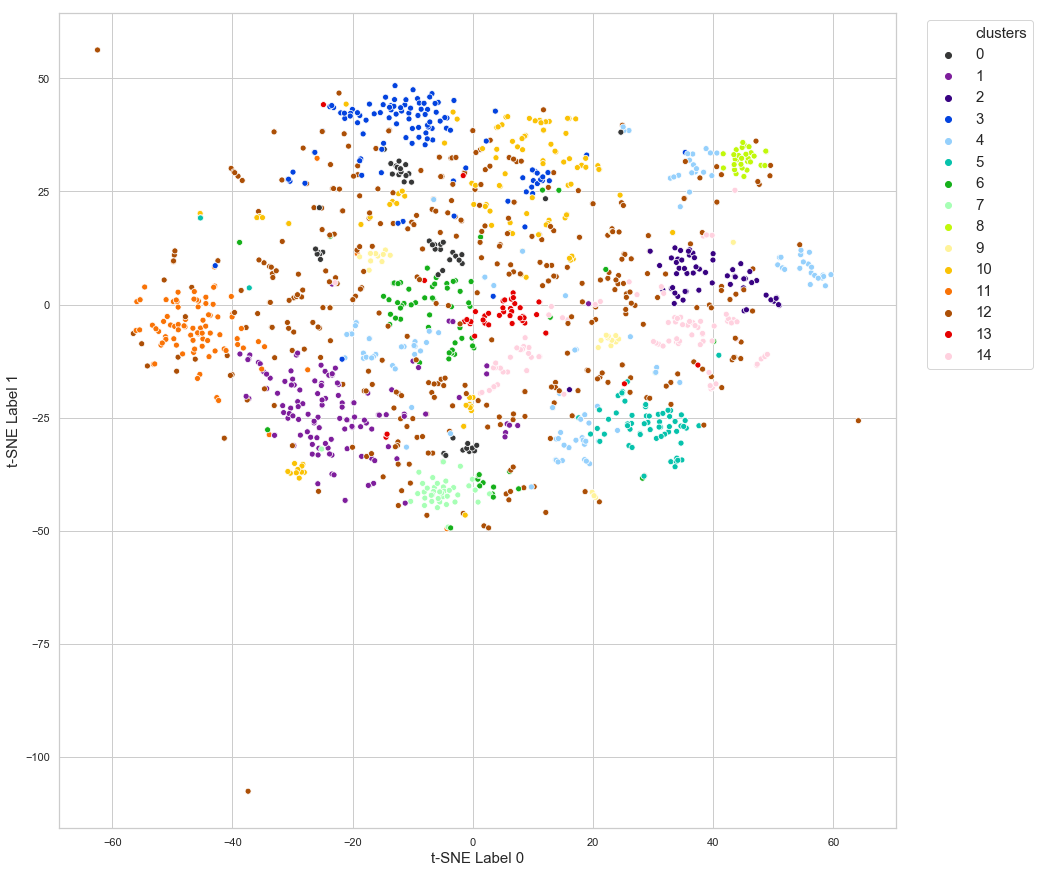

In [22]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.cm as cm

@lru_cache(maxsize = None)
def tsne_plot():
    tsne=TSNE(random_state = 42)

    # Array with 2 dimensions for each sample
    tsne_features=tsne.fit_transform(tfidf)

    # Data frame of cluster labels and t-SNE features for plotting
    tsne_df = pd.DataFrame({'clusters':cluster_labels, 'tsne0':tsne_features[:,0], 'tsne1':tsne_features[:,1]})
    tsne_df['clusters'] = tsne_df['clusters'].astype('category', ordered = True)

    # Palette for plotting
    palette = ['#363737', # dark grey
               '#7e1e9c', # purple
               '#380282', # indigo
               '#0343df', # blue
               '#95d0fc', # light blue
               '#06c2ac', # turquoise
               '#15b01a', # green
               '#a7ffb5', # light green
               '#c1f80a', # chartreuse
               '#fff39a', # yellow
               '#fac205', # gold
                '#f97306', # orange
               '#ac4f06', # brown
               '#e50000', # red
               '#ffd1df', # light pink               
                ]
    sns.set(style="whitegrid")

    # Scatterplot colored by cluster label
    plt.figure(figsize = [15,15])
    sns.scatterplot(data = tsne_df, x="tsne0", y="tsne1", hue="clusters", palette= palette)
    plt.legend(loc='upper center', bbox_to_anchor=(1.1, 1), ncol=1, fontsize =15)
    plt.xlabel("t-SNE Label 0", size = 15)
    plt.ylabel("t-SNE Label 1", size = 15)

    plt.show()
    
warnings.filterwarnings('ignore')
tsne_plot()

Just as we saw in the silhouette plot, cluster 12 is very widespread. In general, it seems like this clustet isn't that informative.

## Word cloud for each cluster
Visualization of the printed terms above

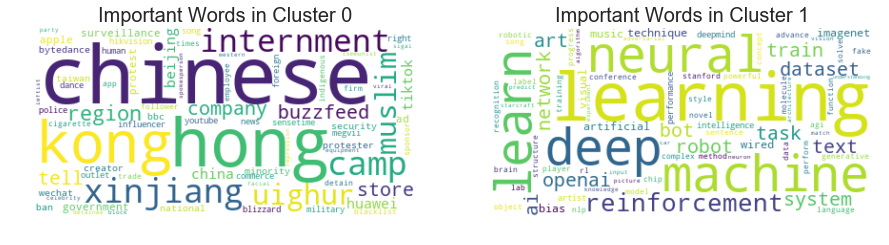

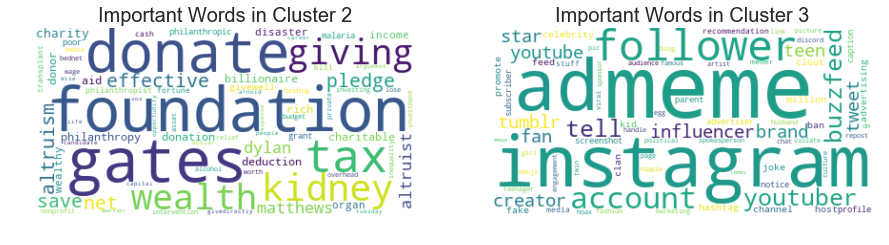

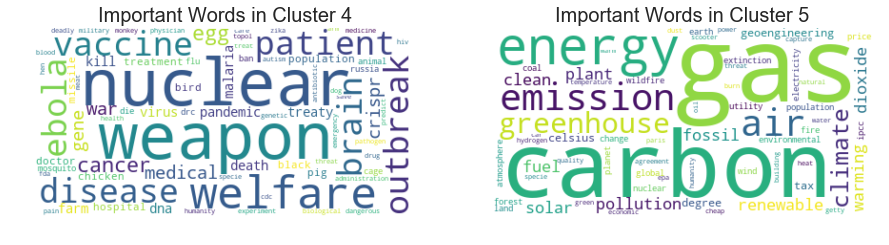

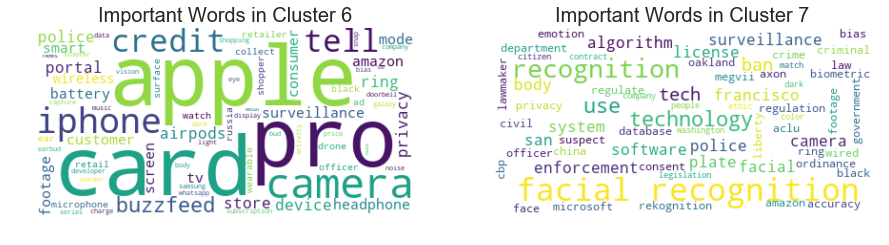

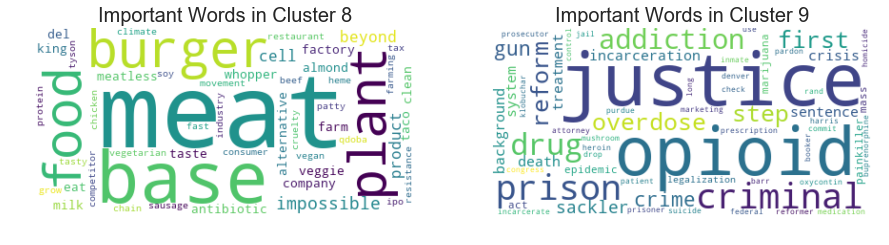

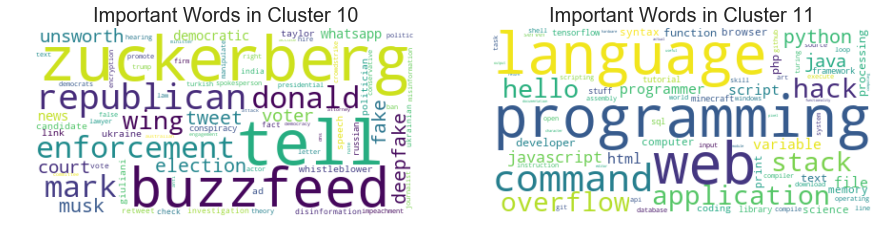

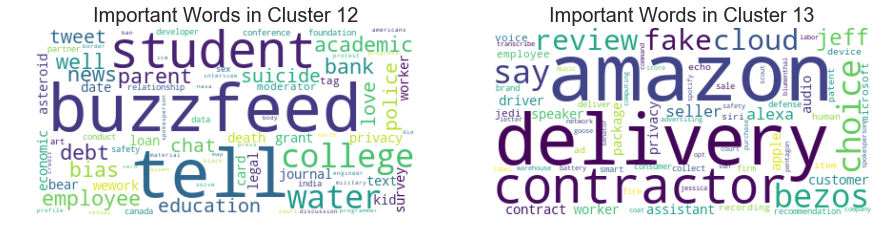

In [23]:
def print_word_cloud_per_cluster():
    sorted_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

    j = 2
    while j < k:
        f, axs = plt.subplots(1,2, figsize = [15, 5])
        
        # for each of the two axes, create a word cloud for that cluster's most important terms, and display it
        for ax, i in zip(axs, range(j-2, j)):
            cloud = WordCloud(background_color = 'white').generate(text=(' '.join(np.array(terms)[sorted_centroids[i, :75]])))
            title = "Important Words in Cluster {}".format(i)

            ax.imshow(cloud, interpolation="bilinear")
            ax.set_title(title, size = 20)
            ax.grid(False)
            ax.axis("off")
            
            # update j for next loop
            j=j+1
        
        plt.show()

print_word_cloud_per_cluster()

# Prediction with new document content

In [9]:
import os
from sklearn.externals import joblib
import spacy
sp = spacy.load('en_core_web_sm')
from wordcloud import WordCloud
import matplotlib.pyplot as plt

vectorizer = joblib.load('models/tfidf_vectorizer.sav')

kmeans = joblib.load('models/kmeans.sav')

def predict(input_string = None, filename = None):
    '''
    A function to clean, vectorize, and predict the kmeans cluster of a new string
    
    Arguments: a string, which is the content of an article OR the 'filename.txt' of a text file
    
    Output: a prediction and wordcloud for the document
    '''
    if filename != None:
        with open(os.path.join(PROJ_ROOT_DIR, "content_to_predict", filename), 'r') as file:
            input_string = file.read()
        print('Processing file')
        # Clean the string
        clean = clean_string(input_string)
    
    if input_string != None:
        print('Processing text string')
        clean = clean_string(input_string)


    # Vectorize the string
    Y = vectorizer.transform([clean])

    # Predict the cluster label
    prediction = kmeans.predict(Y)
    
    # Generate the wordcloud
    cloud = WordCloud(background_color = 'white').generate(clean)
    
    # Add the prediction to the title of the word cloud
    title = "Cluster Prediction for Article {}".format(prediction)
    
    # Show the word cloud
    plt.figure(figsize = [10,15])
    plt.imshow(cloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, size =20)
    plt.show();

Processing text string


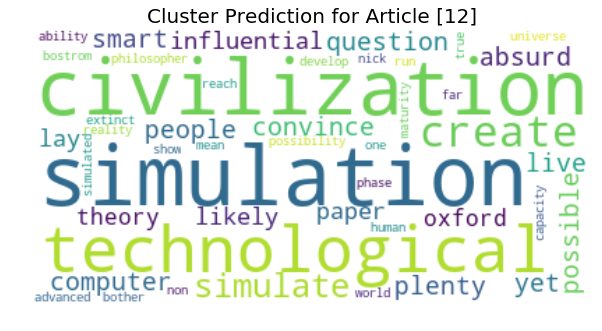

In [14]:
predict(input_string = '''Are we living in a computer simulation? The question seems absurd. Yet there are 
plenty of smart people who are convinced that this is not only possible but perhaps likely.In an influential 
paper that laid out the theory, the Oxford philosopher Nick Bostrom showed that at least one of three 
possibilities is true: 1) All human-like civilizations in the universe go extinct before they develop the 
technological capacity to create simulated realities; 2) if any civilizations do reach this phase of 
technological maturity, none of them will bother to run simulations; or 3) advanced civilizations would have 
the ability to create many, many simulations, and that means there are far more simulated worlds than 
non-simulated ones.''')